# Goal: Understand and Implement Backpropagation from Scratch
In this demo, we will implement backpropagation from scratch. Let's set things up by writing out our recipe for machine learning:
## 3 Step Recipe:
- Fix a representation (neural networks, parameterized by weights $\theta$)
- Define a measure of goodness $\rightarrow$ Loss Function $L(\theta)$
- Choose an optimization strategy (gradient descent)


Gradient Descent:
- $L(\theta)$
- $g_t \leftarrow \nabla_{\theta}L(\theta_{t-1})$ **(this notebook)**
-  $\theta_t \leftarrow \theta_{t-1} - \lambda g_t$


This notebook explores how to efficiently calculate the gradient in the equations above and is based off Andrej Karpathy's [notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb) and [lecture](https://www.youtube.com/watch?v=VMj-3S1tku0&t=0s). 

Additional sources:
- [CS231n notes](https://cs231n.github.io/optimization-2/)
- [Deep Learning notes](https://chinmayhegde.github.io/dl-notes/notes/lecture02/#the-backpropagation-algorithm) [from this course](https://chinmayhegde.github.io/dl-notes/notes/lecture03/#automatic-differentiation)


Let's start by importing some packages.

In [30]:
import math
import random
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

Similar to the previous notebook, let's first start with a simple function where we can think of $f$ as being our loss function $L$ and $\{a,b,c\}$ as being our trainable network parameters $\theta$. Let's also fix ourselves somewhere along this function.

## $f(a,b,c) = (a \cdot b) + c$

- $a = 2$
- $b = -3$
- $c = 10$

We want the following values in order to run gradient descent and obtain a lower value of our loss function.
- $\partial f / \partial a$
- $\partial f / \partial b$
- $\partial f / \partial c$



In [31]:
def f(a,b,c):
    return a*b + c

a = 2.0
b = -3.0
c = 10.0

print("f:", f(a,b,c))

f: 4.0


## Analytical Method
We can use what we learned in calculus to find these derivatives by hand:

In [32]:
def df_da(a,b,c):
    return b

def df_db(a,b,c):
    return a

def df_dc(a,b,c):
    return 1

print("df/da:", df_da(a,b,c))
print("df/db:", df_db(a,b,c))
print("df/dc:", df_dc(a,b,c))

df/da: -3.0
df/db: 2.0
df/dc: 1


## Numerical Method

We could also approximate the derivatives using finite differences.

In [33]:
h = 0.0000001

num = f(a+h,b,c) - f(a,b,c)
print("df/da:",num/h)
num = f(a,b+h,c) - f(a,b,c)
print("df/db:",num/h)
num = f(a,b,c+h) - f(a,b,c)
print("df/dc:",num/h)

df/da: -2.9999999995311555
df/db: 1.9999999967268423
df/dc: 0.999999993922529


## Key Takeaways
For the above approaches,
- works well for small computational graphs
- numerical approach is approximate
- take a lot of computation

And so both methods won't scale well with neural networks that are composed of many *layers* and contain millions of parameters

Now, let's instantiate this same example in Torch and see how we calculate the derivatives.

In [34]:
import torch
ta = torch.tensor([2.0], requires_grad=True)
tb = torch.tensor([-3.0], requires_grad=True)
tc = torch.tensor([10.0], requires_grad=True)
tf = (ta * tb ) + tc # forward pass
tf.backward() # backprop
print("df/da:", ta.grad)
print("df/db:", tb.grad)
print("df/dc:", tc.grad) 

df/da: tensor([-3.])
df/db: tensor([2.])
df/dc: tensor([1.])


The grad values given by torch are in agreement with our manual calculations above.

During the forward pass, torch builds a *computational graph* of our function. Then, the call to `backward()` performs backpropagation on this computational graph which calculates the derivatives at our input values! I find the following graphic (from Boaz Barak) useful in understanding backpropagation. 

<img src="https://windowsontheory.files.wordpress.com/2021/12/backprop.png?w=1024" width="700">

The key idea is that the multivariate chain rule lets us compute $dz/du$ using only information about $u$'s children in the feedforward network. [This page from CS231n](https://cs231n.github.io/optimization-2/#backprop) along with its [lecture](https://youtu.be/i94OvYb6noo?t=322) walk through backprop on a simple computational graph. Let's build up our own **simplified** version of what torch is doing under the hood.

### Building the `Value` class for backpropagation

We'll start by building a class to easily store gradients and recursively calculate them.

Once we've implemented it, our value function should behave as follows.

```
a = Value(4)
print(a.grad) # 0
def f(x): return x*x*x + x*x  # x^3 + x^2
f(a).backward()
print(a.grad) # 56 = 3*(x)**2 + 2x when x = 4
```

Let's iteratively building up our `Value` class.

## Building `Value`: Step 1

First, we will start by initializing our `Value` object with our data (we will just focus on `float` objects) and define methods for adding and multiplying two `Value` class. 

In [35]:
class Value:
    def __init__(self, data, label=''):
        self.data = data
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

At this point, we can add and multiply two value objects and also print them:

In [36]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
c = a+b
d = a*b

# little hacky but works for the purpose of this notebook
c.label = 'c'
d.label = 'd'
print(a)
print(b)
print(c)
print(d)

Value(data=3.0)
Value(data=2.0)
Value(data=5.0)
Value(data=6.0)


## Building `Value`: Step 2

However, we would like to build a computational graph similar to Torch. So let's add that functionality as well. When a new `Value` object is created in our computational graph, we need to keep track of what `Value` nodes were used to create it (`_children`). We will also keep a track of what mathematical operation was used to create our new `Value` node (`_op`). Finally, we will have a `grad` attribute (similar to Torch's).

In [37]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

At this point, we can build up a computation graph, keep a track of children / parent nodes. Let's add in some code to draw this information. The following cell uses `graphviz` to plot our computational graphs.

In [38]:
## you can ignore this cell; just used for plotting our graphs
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        # dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Now, let's draw the example function we have been working with! We are going to break down our function into its basic building blocks: additions and multiplications. We will also name the intermediate values.

Value(data=4.0)


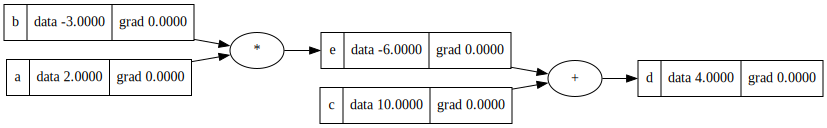

In [39]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; 
d.label='d'
print(d)
draw_dot(d)

We can see that our function is now represented as a computational graph and each `Value` object has its associated `data` attribute filled in. The final `Value` node `d` contains the evaluation of calling this function on our specified inputs: `d.data = 4`. This is essentially performing a forward pass with our inputs. Let's add one more layer of complexity to our function.

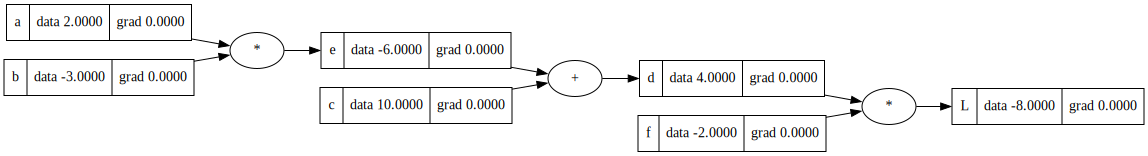

In [40]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c;
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label='L'
draw_dot(L)

At this point, we would like to fill in the `grad` attributes using backpropagation. Let's walk through backpropagation step-by-step, and then add the functionality to our `Value` class.

### $\frac{dL}{dL}$

We start with the final `Value` node in our graph: $\frac{dL}{dL}$. This is the base case and $\frac{dL}{dL}$ is just 1! So let's fill that in and redraw.

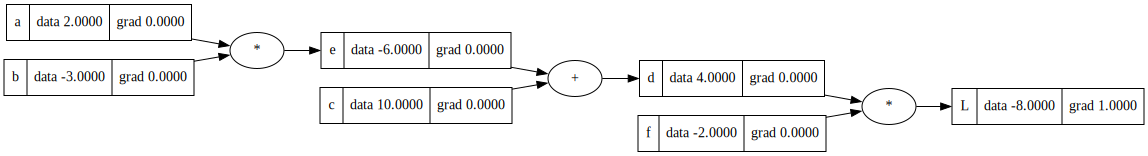

In [41]:
L.grad = 1.0
draw_dot(L)

### $\frac{dL}{df}$ and $\frac{dL}{dd}$

Now, we can move backwards one layer in our graph. We would like to compute $\frac{dL}{df}$ and $\frac{dL}{dd}$. We know that $L = d \cdot f$, so we can use our rules of differentiation to write out the derivative.

- $\frac{dL}{df} = d$
- $\frac{dL}{dd} = f$

And so we can fill in the `grad` attribute of `d` and `f` now.

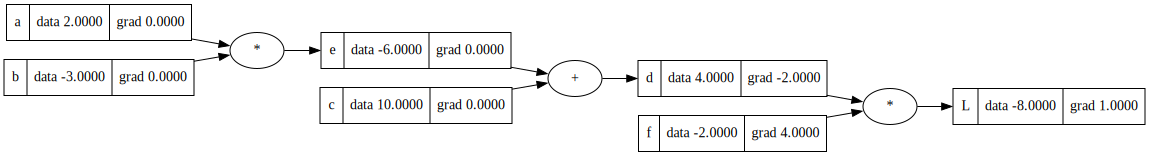

In [42]:
f.grad = d.data
d.grad = f.data
draw_dot(L)

### $\frac{dL}{de}$ and $\frac{dL}{dc}$

Again, let's move back one layer. We can now make use of the just-computed $\frac{dL}{dd}$ to find $\frac{dL}{de}$ and $\frac{dL}{dc}$ (we don't need to worry about $\frac{dL}{df}$ since $f$ is a leaf node). This is where we will see the chain rule coming into play:

- $\frac{dL}{de} = \frac{dd}{de} \cdot \frac{dL}{dd}$
- $\frac{dL}{dc} = \frac{dd}{dc} \cdot \frac{dL}{dd}$

In both cases, the first term in the chain rule expression is the local influence of our variable ($e$ or $c$) on the following node ($d$), and the second term is the global influence of the following node ($d$) on our loss value ($L$). 

Since we know that $d$ is defined as $d = e + c$, we can calculate both $\frac{dd}{de}$ and $\frac{dd}{dc}$ and substitute in our value of $\frac{dL}{dd}$.

- $\frac{dL}{de} = 1 \cdot (-2)$
- $\frac{dL}{dc} = 1 \cdot (-2)$

And now, we can populate the `grad` attribute for both `e` and `c`.

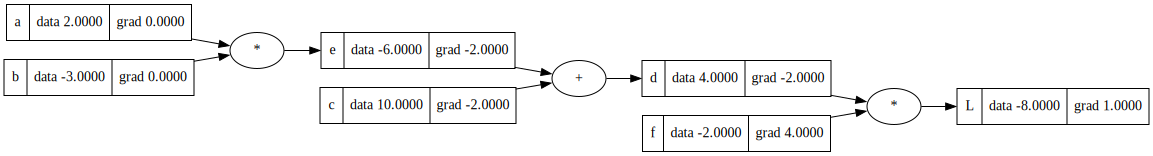

In [43]:
e.grad = 1 * d.grad
c.grad = 1 * d.grad
draw_dot(L)

### $\frac{dL}{da}$ and $\frac{dL}{db}$

Again, we move backwards through our graph and arrive at our first layer. We can now make use of the just-computed $\frac{dL}{de}$ to find $\frac{dL}{da}$ and $\frac{dL}{db}$. 

- $\frac{dL}{da} = \frac{de}{da} \cdot \frac{dL}{de}$
- $\frac{dL}{db} = \frac{de}{db} \cdot \frac{dL}{de}$

We know that $e$ is defined as $e = a \cdot b$, so we can calculate both $\frac{dd}{da}$ and $\frac{dd}{db}$ and substitute in our value of $\frac{dL}{de}$.

- $\frac{dL}{da} = b \cdot (-2)$
- $\frac{dL}{db} = a \cdot (-2)$

Finally, we can fill in the `grad` attribute for `a` and `b`. 

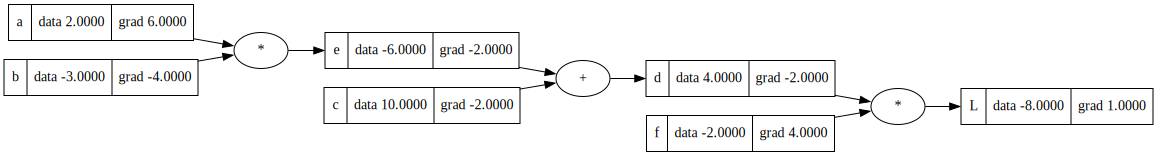

In [44]:
a.grad = b.data * e.grad
b.grad = a.data * e.grad
draw_dot(L)

As a sanity check, let's build the same computational graph in PyTorch and make sure our leaf nodes have the same gradient values as our manual calculation:

In [45]:
a_tch = torch.tensor([2.0], requires_grad=True)
b_tch = torch.tensor([-3.0], requires_grad=True)
c_tch = torch.tensor([10.0], requires_grad=True)
f_tch = torch.tensor([-2.0], requires_grad=True)
L = ((a_tch * b_tch) + c_tch) * f_tch
print(L)
L.backward()
print("a.grad:", a_tch.grad)
print("b.grad:", b_tch.grad)
print("c.grad:", c_tch.grad)
print("f.grad:", f_tch.grad)

tensor([-8.], grad_fn=<MulBackward0>)
a.grad: tensor([6.])
b.grad: tensor([-4.])
c.grad: tensor([-2.])
f.grad: tensor([4.])


Indeed the `grad` attribute from Torch for the leaf nodes match our calculations. As an exercise, you could also verify our gradient calcuations by using the numerical method we used at the beginning of this notebook.

## Building `Value`: Step 3

Let's now add in our implementations of backpropagation for the two types of operations we have defined: addition and multiplication. So suppose we are currently at some `Value` node $f$ that takes as input nodes $x$ and $y$. Let's also suppose we have $\frac{dL}{df}$ and want to compute $\frac{dL}{dx}$ and $\frac{dL}{dy}$.

We observe the following for an addition node $f = x + y$:

- $\frac{df}{dx} = 1$
- $\frac{df}{dy} = 1$

For a multiplication node $f = x \cdot y$, we observe that:
- $\frac{df}{dx} = y$
- $\frac{df}{dy} = x$

We just need to multiply these local derivatives with our node's global derivative $\frac{dL}{df}$ to get $\frac{dL}{dx}$ and $\frac{dL}{dy}$. 

**One caveat**: $x$ and $y$ may be used to generate more than one `Value` node later in our graph, so we need to accumulate the gradients for all of its successor nodes.

We will add in an internal `_backward` pass for both addition and multiplication and define a method `backward` that can be called on the final `Value` node of any computational graph.

In [48]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
    
        def _backward():
            self.grad += 1 * out.grad # += since we are accumulating gradients over all children of self.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        
      
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1
        # go one variable at a time and apply the chain rule to get its gradient
        for v in reversed(topo):
            v._backward()

      

Now, let's reinstiate our computational graph and call `backward` on our final `Value` node `L`. Note that `backward` will then set `L.grad=1`.

Value(data=-8.0)


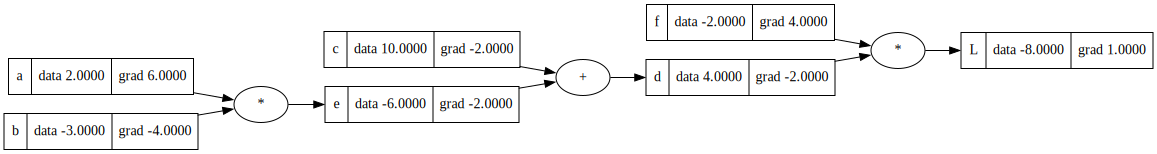

In [49]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c;
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label='L'
print(L)
L.backward()
draw_dot(L)

Our `grad` attributes calculated by `backward` match our `grad` attributes we calculated by hand! And so we've implemented backprop from scratch but just for two operations (multiplication and addition). Feel free to add your own operations such as $x^2$ or $\max(x,y)$. As we've seen in this notebook, you just need to
- define the forward pass of your function (like $x^2$ or $\max(x,y)$)
- define the local gradient of your function with respect to its inputs

Now that we've gone through the process for addition and multiplication, take a look at [Figure 1 of this blog post from PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/). You can see that for each function in the computational graph, PyTorch keeps a track of how to evaluate the local gradient with respect to its inputs (for example, `SinBackward`). 
